In [1]:
import random
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

In [9]:
class EvolvingGraphPageRank():
    
    def __init__(self):
        self.initial_graph = {} # The first constructed graph
        self.new_graph = {} # latest graph after running construct_new_graph()
        self.updated_graph = {} # The updated graph after running construct_new_graph() and update_graph()
        self.image = OrderedDict() # The graph updated based on probing
        self.current_pagerank = {} # PageRank latest graph after running construct_new_graph()
        self.updated_pagerank = {} # PageRank of the updated graph after running construct_new_graph() and update_graph()
        self.num_changes = 0
        self.probe_pagerank = {}
        self.updated_pagerank = {}
        self.probenode = 0
        self.probeneighbours = []
        self.probe_changes = 0
        self.L_inf = OrderedDict()
        self.L1 = OrderedDict()
        self.priority = {}

        
    def construct_initial_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.initial_graph:
                self.initial_graph[f] = []
                self.updated_graph[f] = []
                self.image[f] = []
            self.initial_graph[f].append(t)
            self.updated_graph[f].append(t)        
            self.image[f].append(t)        

    def construct_new_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.new_graph:
                self.new_graph[f] = []
            self.new_graph[f].append(t)
        
        
    def update_image(self):
        
        if self.probenode in self.updated_graph:
            if sorted(self.probeneighbours) == sorted(self.updated_graph[self.probenode]):
                pass
            else:
                for i in self.probeneighbours:
                    if i not in self.updated_graph[self.probenode]:
                        self.image[self.probenode].remove(i)
                        self.probe_changes+=1
                
                for i in self.updated_graph[self.probenode]:
                    if i not in self.probeneighbours:
                        if i not in self.image:
                            self.image[i] = []
                        self.image[self.probenode].append(i)
                        self.probe_changes+=1
                        
        else:
            for i in list(self.image.keys()):
                if self.probenode in self.image[i]:
                    self.image[i].remove(self.probenode)
                    self.probe_changes+=1
            self.image.pop(self.probenode)
            
        self.probe_pagerank = self.PowerIteration(0.15, self.image)
        self.updated_pagerank = self.PowerIteration(0.15, self.updated_graph)
        
        
        
        
    def update_graph(self, method = 'Random'):
        for node in self.new_graph: 
            if node in self.updated_graph:
                if sorted(self.new_graph[node]) == sorted(self.updated_graph[node]): # checking if neighbours matches for nodes in both new and updated graphs
                    pass
                else: 
                    for i in self.new_graph[node]:                     # adding neighbours
                        if i not in self.updated_graph[node]:
                            if i not in self.updated_graph:
                                self.updated_graph[i] = []
                            self.updated_graph[node].append(i)
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                                self.update_priority()
                            self.metrics()
                            self.num_changes += 1

                    temp = self.updated_graph[node].copy()
                    for i in temp:                                    # removing neighbours
                        if i not in self.new_graph[node]:
                            self.updated_graph[node].remove(i)
                            
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                                self.update_priority()
                            self.metrics()
                            self.num_changes += 1
                    
            elif node not in self.updated_graph:
                
                temp = self.new_graph[node].copy()
                self.updated_graph[node] = []
                for i in temp:
                    if i not in self.updated_graph:
                        self.updated_graph[i] = []
                    self.updated_graph[node].append(i)
                    if method == 'Random':
                        self.random_probing()
                        self.update_image()

                    elif method == 'RoundRobin':
                        self.roundrobin_probing()
                        self.update_image()

                    elif method == 'Proportional':
                        self.proportional_probing()
                        self.update_image()

                    elif method == 'Priority':
                        self.priority_probing()
                        self.update_image()
                        self.update_priority()
                    self.metrics()
                    self.num_changes += 1
                    
                    
                    
        for i in list(self.updated_graph.keys()): # removing nodes not in new graph
            if i not in self.new_graph:
                self.updated_graph.pop(i) # node removed
                
                
        return self.L_inf, self.L1
            
    
    def PowerIteration(self, alpha, graph):
        pi_prev = {node: 1 / len(graph) for node in graph}
        pi_current = {node: 0 for node in graph}
        abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
        while abs_diff >= 1e-9:
            for node, neighbors in graph.items():
                if len(neighbors) > 0:
                    for neighbor_node in neighbors:
                        if neighbor_node in graph:
                            pi_current[neighbor_node] += pi_prev[node] / len(neighbors)
            pi_current = {node: (1 - alpha) * pi_current[node] + alpha / len(graph) for node in graph}
            abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
            pi_prev = pi_current
            pi_current = {node: 0 for node in graph}
        return pi_prev
    

    
    
    
    def random_probing(self):
        self.probenode = random.choice(list(self.image.keys()))
        self.probeneighbours = self.image[self.probenode]
        
        
        
    def roundrobin_probing(self):
        if self.probe_changes == 0:
            self.probenode = list(self.image.keys())[0]
        else:
            if self.probenode == list(self.image.keys())[-1]:
                self.probenode = list(self.image.keys())[0]
            else:
                self.probenode = list(self.image.keys())[list(self.image.keys()).index(self.probenode) + 1]
        
        
    def proportional_probing(self):
        pagerank_weights = {}
        sum_ = sum([self.image[i] for i in self.image])
        
        for node in self.probe_pagerank:
            pagerank_weights[node] = self.probe_pagerank[node] / sum_
        self.probenode = random.choices(list(self.image), weights = pagerank_weights)[0]
        self.probeneighbours = self.image[self.probenode]
        
        
    def priority_probing(self):
        for node in self.image.keys():
            if node not in self.priority:
                self.priority[node] = 0
                
        max_priority = max([self.probe_pagerank[i] for i in self.probe_pagerank])
        self.probenode = list(self.image.keys())[list(self.image.values).index(max_priority)]
        self.probeneighbours = self.image[self.probenode]
        
        
    def update_priority(self):
        self.priority[self.probenode] = 0
        
        for node in self.priority:
            if node == self.probenode:
                continue
                
            self.priority[node] += self.probe_pagerank[node]
        
        
        
    def metrics(self):
        
        if self.probenode not in self.L_inf:
            self.L_inf[self.probenode] = 0
            
        self.L_inf[self.probenode] = max([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        
        if self.probenode not in self.L1:
            self.L1[self.probenode] = 0
        
        self.L1[self.probenode] = sum([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        

In [10]:
randomprobinggraph = EvolvingGraphPageRank()
randomprobinggraph.construct_initial_graph("as-733/as19971108.txt")
directory = 'as-733'
c = 0
random_changes = []
random_Linf = []
random_L1 = []


for filename in os.listdir(directory):
    c += 1
    print(c, filename)
    if c != 1:
        randomprobinggraph.construct_new_graph(f"{directory}/{filename}")
        randomprobinggraph.update_graph(method = 'Random')
        
        

1 as19971108.txt
2 as19971109.txt
3 as19971110.txt
4 as19971111.txt
5 as19971112.txt
6 as19971113.txt
7 as19971114.txt
8 as19971115.txt
9 as19971116.txt
10 as19971117.txt
11 as19971118.txt
12 as19971119.txt
13 as19971120.txt
14 as19971121.txt
15 as19971122.txt
16 as19971123.txt
17 as19971124.txt
18 as19971125.txt
19 as19971126.txt
20 as19971127.txt
21 as19971128.txt
22 as19971129.txt
23 as19971130.txt
24 as19971201.txt
25 as19971202.txt
26 as19971203.txt
27 as19971204.txt
28 as19971205.txt
29 as19971206.txt
30 as19971207.txt
31 as19971208.txt
32 as19971209.txt
33 as19971210.txt
34 as19971211.txt
35 as19971212.txt
36 as19971213.txt
37 as19971214.txt
38 as19971215.txt
39 as19971216.txt
40 as19971217.txt
41 as19971218.txt
42 as19971219.txt
43 as19971220.txt
44 as19971221.txt
45 as19971222.txt
46 as19971223.txt
47 as19971224.txt
48 as19971225.txt
49 as19971226.txt
50 as19971227.txt
51 as19971228.txt
52 as19971229.txt
53 as19971230.txt
54 as19971231.txt
55 as19980101.txt
56 as19980102.txt
5

KeyboardInterrupt: 

In [39]:
# randomprobinggraph.construct_new_graph("as-733/as19971109.txt")

In [40]:
# randomprobinggraph.update_graph(method = 'Random')

In [41]:
# randomprobinggraph.L_inf

In [16]:
randomprobinggraph.num_changes

3420

In [17]:
randomprobinggraph.probe_changes

1283

In [18]:
len(randomprobinggraph.L_inf)

2081

1 6673 0.003126526089950085
2 7325 0.0034922372019082176
3 3856 0.00013982126995950792
4 4860 0.0022147988181057537
5 4232 0.0040728088498175885
6 45 0.0001800033859915614
7 4490 0.00018098412157387458
8 7501 0.0017393212607074784
9 1754 0.0029475238887167023
10 3332 0.0007816344108480117
11 48 0.00015828130134963418
12 1913 0.0021011058379304948
13 4600 0.0015002384187054463
14 5213 0.0001898318669418149
15 8463 0.003481150039664654
16 6770 0.0014964476805686688
17 8485 0.0019088198414964133
18 7882 0.002139121117578781
19 6437 0.00018260517512461226
20 1660 0.0034679582486754307
21 7144 0.00018223024440641548
22 7881 0.0016606244204976292
23 2707 0.0034802583021168077
24 55 0.00255487424470556
25 5671 0.00018081323362143984
26 7981 0.0029609897841873663
27 6461 0.0014980374647008202
28 1569 0.0029582487790123313
29 1880 0.0028222558347102936
30 7565 0.002970599412913295
31 8037 0.001833977384654302
32 2899 0.0001762812978143946
33 3303 0.0035967041323014173
34 5645 0.0002191204511819

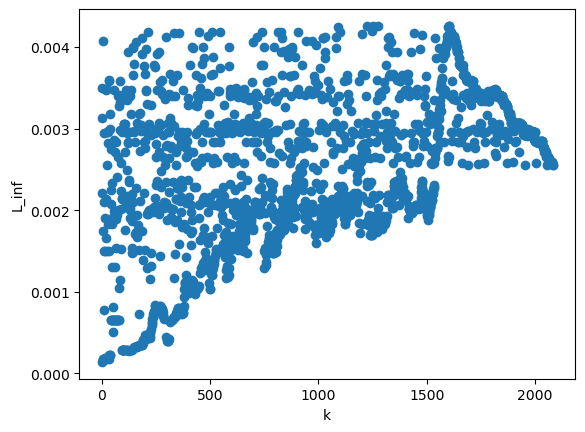

In [12]:
k = 0
k_values = []
L_inf_values = []

for _, L_inf in randomprobinggraph.L_inf.items():
    k += 1
    k_values.append(k)
    L_inf_values.append(L_inf)
    print(k, _, L_inf)

plt.scatter(k_values, L_inf_values)
plt.xlabel('k')
plt.ylabel('L_inf')
plt.show()

In [73]:
roundrobinprobinggraph = EvolvingGraphPageRank()
roundrobinprobinggraph.construct_initial_graph("as-733/as19971108.txt")
directory = 'as-733'
c = 0
roundrobin_changes = []
roundrobin_Linf = []
roundrobin_L1 = []


for filename in os.listdir(directory):
    c += 1
    print(c, filename)
    if c != 1:
        roundrobinprobinggraph.construct_new_graph(f"{directory}/{filename}")
        roundrobinprobinggraph.update_graph(method = 'RoundRobin')
        

k = 0
k_values = []

for _, L_inf in roundrobinprobinggraph.L_inf.items():
    k += 1
    k_values.append(k)
    roundrobin_Linf.append(L_inf)
    print(k, _, L_inf)

plt.plot(k_values, roundrobin_Linf)
plt.xlabel('k')
plt.ylabel('L_inf')
plt.show()  

1 as19971108.txt
2 as19971109.txt
3 as19971110.txt
4 as19971111.txt
5 as19971112.txt
6 as19971113.txt
7 as19971114.txt
8 as19971115.txt
9 as19971116.txt
10 as19971117.txt
11 as19971118.txt
12 as19971119.txt
13 as19971120.txt
14 as19971121.txt
15 as19971122.txt
16 as19971123.txt
17 as19971124.txt
18 as19971125.txt
19 as19971126.txt
20 as19971127.txt
21 as19971128.txt
22 as19971129.txt
23 as19971130.txt
24 as19971201.txt
25 as19971202.txt
26 as19971203.txt
27 as19971204.txt
28 as19971205.txt
29 as19971206.txt
30 as19971207.txt
31 as19971208.txt
32 as19971209.txt


ValueError: 1 is not in list